In [1]:
import os

FOOTBALL_PATH = "/Users/sebastiennunes/Documents/McGill/Schoolwork/ECON 420/mlalgorithm"

def load_football_data(football_path=FOOTBALL_PATH):
    csv_path = os.path.join(football_path, "football_data_final.csv")
    return pd.read_csv(csv_path)

In [2]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import clean_data as cd
# Import supplementary visualization code visuals.py, renamed as visuals_udacity.py. I have taken this code from the Udacity
# machine learning projects
from utilityFunctions import *

# Pretty display for notebooks
%matplotlib inline
conn = cd.open_sqlite()
print ("Players")
players_df = cd.sql_to_dataframe(conn, select_all_query_table("Player_Attributes"))
display(players_df.head(n=1))
print ("Teams")
teams_df = cd.sql_to_dataframe(conn, select_all_query_table("Team_Attributes"))
display(teams_df.head(n=1))
print ("Matches")
match_df = cd.sql_to_dataframe(conn, select_all_query_table("Match"))
display(match_df.head(n=1))

Players


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


Teams


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


Matches


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


In [26]:
print("**********\nThis simply displays a sample of the data we're working with:\n********** ")
print("(not all this data is being used in the model)")
players_skills = players_df[['player_api_id', 'finishing', 'sliding_tackle', 'gk_reflexes', 'short_passing', 'date']]
players_ratings_label = players_df[['player_api_id','date', 'overall_rating']]
players_features_df = players_df.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential'], axis=1)
display(players_features_df.head(n=10))
teams_features_df = teams_df.drop(['id', 'team_fifa_api_id', 'team_api_id', 'date'], axis=1)
display(teams_features_df.head(n=10))

**********
This simply displays a sample of the data we're working with:
********** 
(not all this data is being used in the model)


,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,left,high,medium,80.0,53.0,58.0,71.0,32.0,73.0,70.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,left,high,medium,79.0,52.0,57.0,70.0,29.0,71.0,68.0,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,left,high,medium,79.0,51.0,57.0,70.0,29.0,71.0,68.0,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,left,high,medium,79.0,51.0,57.0,70.0,29.0,71.0,68.0,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,58,Balanced,NaN,Little,62,Mixed,Organised,45,Normal,70,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,62,Balanced,NaN,Little,45,Mixed,Organised,40,Normal,50,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover
7,58,Balanced,64.0,Normal,62,Mixed,Organised,56,Normal,68,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
8,59,Balanced,64.0,Normal,53,Mixed,Organised,51,Normal,72,...,63,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover
9,60,Balanced,NaN,Little,40,Mixed,Organised,45,Normal,35,...,55,Normal,Organised,30,Deep,70,Double,30,Narrow,Offside Trap


In [4]:
import matches as matches
match_df['result_label'] = match_df.apply(matches.result, axis = 1)
print("**********\nSample of the way the matches are labelled:\n**********")
display(match_df.result_label.sample(n=20))

**********
Sample of the way the matches are labelled:
**********


11656        DRAW
21320        DRAW
5279     AWAY_WIN
8578     HOME_WIN
9402     HOME_WIN
25692        DRAW
3239     AWAY_WIN
24731    HOME_WIN
3082     HOME_WIN
21132    AWAY_WIN
12454    AWAY_WIN
16945        DRAW
14389    AWAY_WIN
14131        DRAW
21387    AWAY_WIN
24015    HOME_WIN
5053     AWAY_WIN
6147     HOME_WIN
22741    AWAY_WIN
6301     HOME_WIN
Name: result_label, dtype: object

In [5]:
import itertools
all_possibilities_form_guide = list(itertools.product(['L', 'W', 'D'], repeat=5))
all_possibilities_form_guide_string_list = list()
for possibility in all_possibilities_form_guide:
    all_possibilities_form_guide_string_list.append(''.join(possibility))
#print all_possibilities_form_guide_string_list
assert len(all_possibilities_form_guide_string_list) == 243

In [7]:
import pandas as pd
from IPython.display import display

football = load_football_data()

# Drop metadata that isn't useful in this application
META_COLUMNS=['Unnamed: 0','season', 'date', 'match_api_id']
# 
football = football.drop(META_COLUMNS, axis =1)

# Drop na
display(football.shape)
football = football.dropna(axis = 0, how = 'any')
display(football.shape)

## Convert form guide to labelled
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_possibilities_form_guide_string_list)
football['HOME_TEAM_FORM_GUIDE'] = le.transform(football['HOME_TEAM_FORM_GUIDE'])
football['AWAY_TEAM_FORM_GUIDE'] = le.transform(football['AWAY_TEAM_FORM_GUIDE'])

LABELS = ['HOME_WIN', 'AWAY_WIN', 'DRAW']
le.fit(LABELS)
transformed_labels = le.transform(football['result_label'])

# Draw features and labels
le_draw = preprocessing.LabelEncoder()
NO_DRAW_LABELS = ['HOME_WIN', 'AWAY_WIN']
le_draw.fit(NO_DRAW_LABELS)


football_no_draws = football[football['result_label'] != 'DRAW']
transformed_labels_no_draws = le_draw.transform(football_no_draws['result_label'])

football_dropped_values = football_no_draws.drop(['num_top_players_home'], axis =1)
football_dropped_values = football_dropped_values.drop(['HOME_WIN_RATE'], axis =1)
football_dropped_values = football_dropped_values.drop(['home_Goalkeeper_rating'], axis =1)
football_dropped_values = football_dropped_values.drop(['home_Defender_rating'], axis =1)
football_dropped_values = football_dropped_values.drop(['away_Goalkeeper_rating'], axis =1)
football_dropped_values = football_dropped_values.drop(['away_Defender_rating'], axis =1)
football_dropped_values = football_dropped_values.drop(['num_top_players_away'], axis =1)
football_dropped_values = football_dropped_values.drop(['AWAY_WIN_RATE_AT_THIS_GROUND'], axis =1)
football_dropped_values = football_dropped_values.drop(['AWAY_WIN_RATE'], axis =1)
football_dropped_values = football_dropped_values.drop(['HEAD_2_HEAD_HOME_TEAM_WINS'], axis =1)
football_dropped_values = football_dropped_values.drop(['num_bottom_players_home'], axis =1)
football_dropped_values = football_dropped_values.drop(['num_bottom_players_away'], axis =1)

football = football.drop(['result_label'], axis =1)
football_no_draws = football_dropped_values.drop(['result_label'], axis =1)

print("**********\nThese are the features, along with their associated data type, that are used in this model:\n**********")
display(football.dtypes)

(21374, 30)

(21360, 30)

**********
These are the features, along with their associated data type, that are used in this model:
**********


HOME_DRAW_RATE                   float64
HOME_DRAW_RATE_THIS_SEASON       float64
AWAY_DRAW_RATE                   float64
AWAY_DRAW_RATE_THIS_SEASON       float64
AWAY_DRAW_RATE_AT_THIS_GROUND    float64
num_top_players_home               int64
num_top_players_away               int64
num_bottom_players_home            int64
num_bottom_players_away            int64
home_team_api_id                   int64
away_team_api_id                   int64
away_Attacker_rating             float64
home_Attacker_rating             float64
away_Defender_rating             float64
home_Defender_rating             float64
away_Goalkeeper_rating           float64
home_Goalkeeper_rating           float64
away_Midfielder_rating           float64
home_Midfielder_rating           float64
HEAD_2_HEAD_HOME_TEAM_WINS       float64
HEAD_2_HEAD_HOME_TEAM_LOSS       float64
HEAD_2_HEAD_DRAW                 float64
HOME_WIN_RATE                    float64
HOME_WIN_RATE_THIS_SEASON        float64
AWAY_WIN_RATE   

In [8]:
# correlations: Home_win_rate is correlated .477 with num_top_players_home
corr_matrix = football.corr()
print("**********\nThis is a correlation matrix, reprented here in terms of correlation with this season's win rate. \n**********")
corr_matrix["HOME_WIN_RATE_THIS_SEASON"].sort_values(ascending=False)

**********
This is a correlation matrix, reprented here in terms of correlation with this season's win rate. 
**********


HOME_WIN_RATE_THIS_SEASON        1.000000
HOME_WIN_RATE                    0.679210
num_top_players_home             0.363212
home_Midfielder_rating           0.344572
home_Goalkeeper_rating           0.290450
home_Defender_rating             0.280843
HOME_TEAM_FORM_GUIDE             0.253436
HEAD_2_HEAD_HOME_TEAM_WINS       0.202221
home_Attacker_rating             0.138910
away_Goalkeeper_rating           0.024761
away_Defender_rating             0.024220
away_Midfielder_rating           0.023660
away_team_api_id                 0.011716
num_top_players_away             0.011334
AWAY_DRAW_RATE                   0.006170
AWAY_TEAM_FORM_GUIDE             0.001927
away_Attacker_rating             0.001305
num_bottom_players_away         -0.004556
AWAY_DRAW_RATE_THIS_SEASON      -0.005476
AWAY_WIN_RATE                   -0.010257
AWAY_WIN_RATE_THIS_SEASON       -0.010721
num_bottom_players_home         -0.011427
HEAD_2_HEAD_DRAW                -0.039573
home_team_api_id                -0

In [11]:
import clean_data as dp
home_advantage_per_country = dp.home_advantage(matches_df=match_df, conn=conn)
print("**********\n Baseline Statistics for benchmarking: \n**********")
display(home_advantage_per_country)
total_num_matches = match_df.shape[0]
total_home_wins = match_df[match_df['result_label'] == 'HOME_WIN'].shape[0]
total_away_wins = match_df[match_df['result_label'] == 'AWAY_WIN'].shape[0]
total_draws = match_df[match_df['result_label'] == 'DRAW'].shape[0]
print ("Home Wins occur about " + str(np.around(np.true_divide(total_home_wins, total_num_matches) * 100, decimals = 2)) + " % of the time")
print ("Away Wins occur about " + str(np.around(np.true_divide(total_away_wins, total_num_matches) * 100, decimals = 2)) + " % of the time")
print ("Home and Away draw about " + str(np.around(np.true_divide(total_draws, total_num_matches) * 100, decimals = 2)) + " % of the time")

**********
 Baseline Statistics for benchmarking: 
**********


,name,percentage_home_win
0,Belgium,46.875000
1,England,45.723684
2,France,44.703947
3,Germany,45.220588
4,Italy,46.635731
5,Netherlands,47.834967
6,Poland,45.312500
7,Portugal,44.249513
8,Scotland,41.666667
9,Spain,48.848684


Home Wins occur about 45.87 % of the time
Away Wins occur about 28.74 % of the time
Home and Away draw about 25.39 % of the time


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# mean-centers and auto-scales the data
standardizedData = StandardScaler().fit_transform(football)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(standardizedData)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['component 1', 'component 2'])
# To get how many principal components was chosen
print("Number of components: " , pca.n_components_)

result = pd.concat([principalDf, match_df[['result_label']]], axis = 1)

Number of components:  2


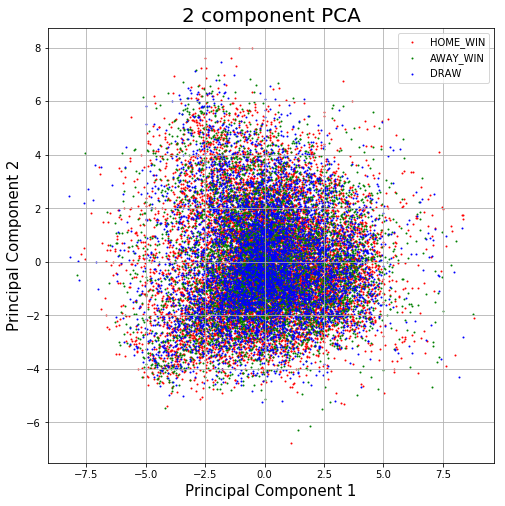

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['HOME_WIN', 'AWAY_WIN', 'DRAW']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = result['result_label'] == target
    ax.scatter(result.loc[indicesToKeep, 'component 1']
               , result.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

In [14]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(standardizedData)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['component 1', 'component 2', 'component 3'])
# To get how many principal components was chosen
print(pca.n_components_)

result = pd.concat([principalDf, match_df[['result_label']]], axis = 1)

3


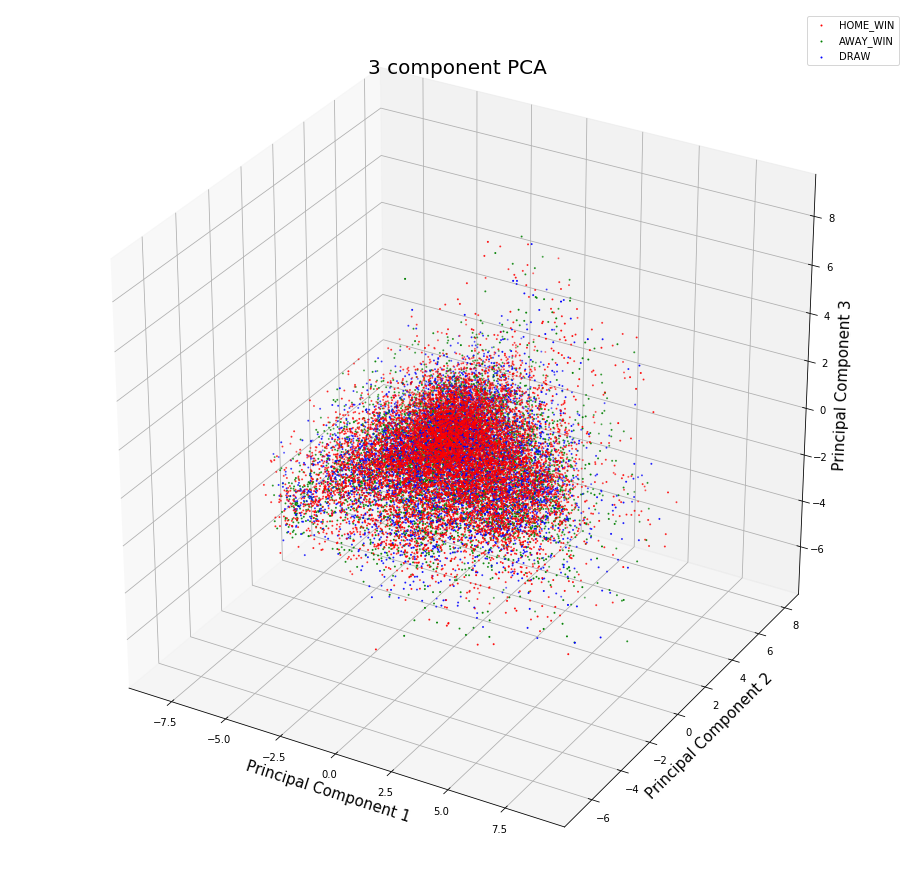

In [15]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16, 16))
ax = plt.axes(projection='3d')

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = ['HOME_WIN', 'AWAY_WIN', 'DRAW']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = result['result_label'] == target
    ax.scatter(result.loc[indicesToKeep, 'component 1']
               , result.loc[indicesToKeep, 'component 2']
               , result.loc[indicesToKeep, 'component 3']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

In [16]:
import matplotlib.pyplot as plt

# Function from the scikit learn spec website to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [28]:
# 1's represent a WIN 
print("*******************************************\nNO DRAWS DATA FORMAT:\n*******************************************" )
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_trainND, X_testND, y_trainND, y_testND = train_test_split(football_no_draws,
                                                    transformed_labels_no_draws, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_trainND.shape[0]))
print ("Testing set has {} samples.".format(X_testND.shape[0]))
print ("Train and Test have {} features. ".format(X_testND.shape[1]))


# small for loop to figure out which number represents a WIN(it's 2)
j = 0;
for result in y_trainND:
    if result == 1:
        j += 1
print("Number of wins in the training set:", j)

*******************************************
NO DRAWS DATA FORMAT:
*******************************************
Training set has 12771 samples.
Testing set has 3193 samples.
Train and Test have 17 features. 
Number of wins in the training set: 7808


In [29]:
#Attempt to train a binary classifier to determine if the match was a win or not (removing draws)
y_train_winND = (y_trainND == 1)

In [30]:
# 2's represent a WIN 
print("*******************************************\nWITH DRAWS DATA FORMAT:\n*******************************************" )
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(football,
                                                    transformed_labels, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))
print ("Train and Test have {} features. ".format(X_test.shape[1]))


# small for loop to figure out which number represents a WIN(it's 2)
j = 0;
for result in y_train:
    if result == 2:
        j += 1
print("Number of wins in the training set:", j)

*******************************************
WITH DRAWS DATA FORMAT:
*******************************************
Training set has 17088 samples.
Testing set has 4272 samples.
Train and Test have 29 features. 
Number of wins in the training set: 7823


In [104]:
# TRAINING A STOCHASTIC GRADIENT DESCENT CLASSIFIER

from sklearn.linear_model import SGDClassifier

# Train the multi-class classifier *with wins*
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)
#loss='default'
sgd_clf.fit(X_train, y_train)

# Train the binary classifier *without wins*
sgd_clfND = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_clfND.fit(X_trainND, y_train_winND)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)

In [95]:
from sklearn.model_selection import cross_val_score

print("Cross-Validation Score (MultiClass): ", cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print("Cross-Validation Score (Binary): ", cross_val_score(sgd_clfND, X_trainND, y_train_winND, cv=3, scoring="accuracy"))

Cross-Validation Score (MultiClass):  [0.27 0.34 0.45]
Cross-Validation Score (Binary):  [0.42 0.46 0.61]


In [96]:
# => accuracy is not the best metric. 
# Here, I evaluate the confusion matrix to more accurately test the performance of the binary & multi classifiers
# like the previous function, this performs K-fold cross validation

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
y_train_predND = cross_val_predict(sgd_clfND, X_trainND, y_train_winND, cv=3)

In [97]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

print("\n*****************\nWith Draws, All Features (Training Data):\n*****************")
print("F-Beta Score: ", fbeta_score(y_train, y_train_pred, average = 'micro', beta = 1))
print("Precision Score: ", precision_score(y_train, y_train_pred, average='micro'))
print("Recall Score: ", recall_score(y_train, y_train_pred, average='micro'))

print("\n*****************\nWithout Draws, Cut-Down Features (Training Data):\n*****************")
print("Precision Score: ", precision_score(y_train_winND, y_train_predND))
print("Recall Score: ", recall_score(y_train_winND, y_train_predND))
print("F-Score: ", f1_score(y_train_winND, y_train_predND))


*****************
With Draws, All Features (Training Data):
*****************
F-Beta Score:  0.39425327715355807
Precision Score:  0.39425327715355807
Recall Score:  0.39425327715355807

*****************
Without Draws, Cut-Down Features (Training Data):
*****************
Precision Score:  0.6082864984969285
Recall Score:  0.5960553278688525
F-Score:  0.602108803932984


In [98]:
from sklearn.metrics import confusion_matrix
print("*****************\nWith Draws:\n*****************")
c_mx = confusion_matrix(y_train, y_train_pred)
print(c_mx)
print("\n")
c_mxND = confusion_matrix(y_train_winND, y_train_predND)
print("*****************\nWithout Draws, Cut-Down Features:\n*****************")
print(c_mxND)

## this matrix represents : [{true negatives, false positives}, {false negatives, true positives}]

*****************
With Draws:
*****************
[[2203    0 2728]
 [1882    0 2452]
 [3289    0 4534]]


*****************
Without Draws, Cut-Down Features:
*****************
[[1966 2997]
 [3154 4654]]


In [102]:
# test results of SGD classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

y_pred = sgd_clf.predict(X_test)
print(sgd_clf.__class__.__name__, accuracy_score(y_test, y_pred))
y_test_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3)

SGDClassifier 0.25023408239700373


******************************
With Draws, Stochastic Gradient Descent CLASSIFIER:
******************************
[[   4 1202   21]
 [   0 1042   20]
 [   1 1959   23]]
Normalized confusion matrix
[[3.26e-03 9.80e-01 1.71e-02]
 [0.00e+00 9.81e-01 1.88e-02]
 [5.04e-04 9.88e-01 1.16e-02]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


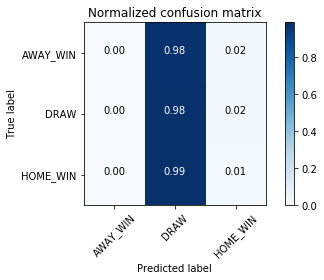

In [103]:
import numpy as np
print("******************************\nWith Draws, Stochastic Gradient Descent CLASSIFIER:\n******************************")
y_pred = sgd_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [56]:
# PLOT PRECISION - RECALL CURVE FOR THE BINARY CLASSIFIER

y_scoresND = cross_val_predict(sgd_clfND, X_trainND, y_train_winND, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisionsND, recallsND, thresholdsND = precision_recall_curve(y_train_winND, y_scoresND)


*****************
Without Draws, Cut-Down Features (SGD CLASSIFIER):
*****************


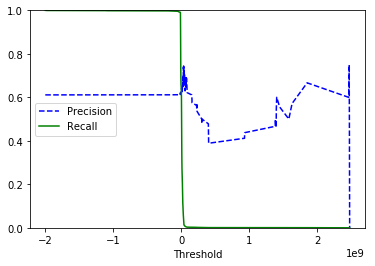

In [58]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

print("\n*****************\nWithout Draws, Cut-Down Features (SGD CLASSIFIER):\n*****************")
plot_precision_recall_vs_threshold(precisionsND, recallsND, thresholdsND)
plt.show()


In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr_sgdND, tpr_sgdND, thresholds_sgdND = roc_curve(y_train_winND, y_scoresND)
print(roc_auc_score(y_train_winND, y_scoresND))

0.5297770355136204


In [62]:
# TRAIN A RANDOM FOREST CLASSIFIER

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

forest_clfND = RandomForestClassifier(random_state=42)
y_probas_forestND = cross_val_predict(forest_clfND, X_trainND, y_train_winND, cv=3,
                                    method="predict_proba")

In [64]:
# PLOT ROC CURVE FOR BINARY CLASSIFIER

y_scores_forestND = y_probas_forestND[:, 1]   # score = proba of positive class
fpr_forestND, tpr_forestND, thresholds_forestND = roc_curve(y_train_winND,y_scores_forestND)

******************************
No Draws, SGD CLASSIFIER:
******************************


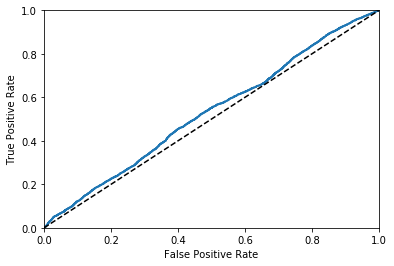

******************************
No Draws, RANDOM FOREST CLASSIFIER:
******************************


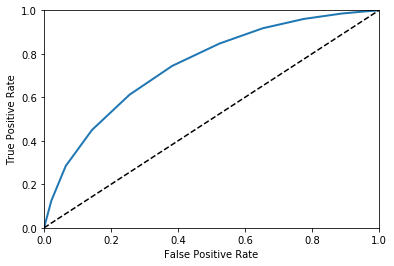

In [65]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

print("******************************\nNo Draws, SGD CLASSIFIER:\n******************************")
plot_roc_curve(fpr_sgdND, tpr_sgdND)
plt.show()
print("******************************\nNo Draws, RANDOM FOREST CLASSIFIER:\n******************************")
plot_roc_curve(fpr_forestND, tpr_forestND)
plt.show()

In [66]:
# MULTI-CLASS CLASSIFICATION (not just a binary Win / not Win)
# SGD model was already fit above but will do so again for clarity
sgd_clf.fit(X_train, y_train)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
# {0,1,2} are the full Multi-Class categories(Loss, Draw, Win)
print(forest_clf.classes_)

[0 1 2]


In [68]:
# test results of Forest classifier (with test data)
from sklearn.model_selection import cross_val_score
import timeit
start_time = timeit.default_timer()

print("With Draws: ", cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy"))

y_pred = forest_clf.predict(X_test)
print(forest_clf.__class__.__name__, accuracy_score(y_test, y_pred))

# gives better results than SGD!
#Best Results so far: [.5, .49, .49]
elapsed = timeit.default_timer() - start_time
round(elapsed, 1)

print("\n*****************\nRandom Forest With Draws, All Features:\n*****************")
print("F-Beta Score: ", fbeta_score(y_test, y_pred, average = 'weighted', beta = 0.5))
print("Precision Score: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score: ", recall_score(y_test, y_pred, average='weighted'))

print("\nThe amont of time elapsed was ", round(elapsed, 2), " seconds.")

With Draws:  [0.49 0.49 0.5 ]
RandomForestClassifier 0.5074906367041199

*****************
Random Forest With Draws, All Features:
*****************
F-Beta Score:  0.4919639698468807
Precision Score:  0.49072958909704334
Recall Score:  0.5074906367041199

The amont of time elapsed was  0.95  seconds.


******************************
RANDOM FOREST CLASSIFIER (Training Data):
******************************
[[2550  817 1564]
 [1213  928 2193]
 [1439 1420 4964]]
Normalized confusion matrix
[[0.52 0.17 0.32]
 [0.28 0.21 0.51]
 [0.18 0.18 0.63]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


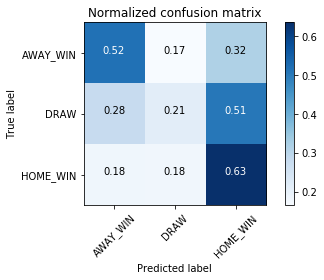

******************************
RANDOM FOREST CLASSIFIER (Test Data):
******************************
[[ 607  193  427]
 [ 292  253  517]
 [ 361  314 1308]]
Normalized confusion matrix
[[0.49 0.16 0.35]
 [0.27 0.24 0.49]
 [0.18 0.16 0.66]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


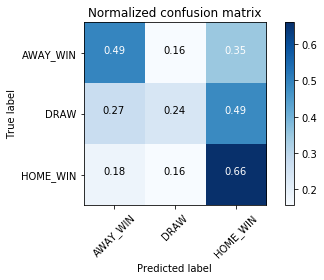

In [69]:
print("******************************\nRANDOM FOREST CLASSIFIER (Training Data):\n******************************")

y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)
# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

print("******************************\nRANDOM FOREST CLASSIFIER (Test Data):\n******************************")

y_test_pred = cross_val_predict(forest_clf, X_test, y_test, cv=3)
conf_mxPRED = confusion_matrix(y_test, y_pred)
print(conf_mxPRED)

# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mxPRED, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [70]:
from sklearn.neighbors import KNeighborsClassifier

# adjusting the number of neighbours changes the accuracy of the model
KB_clf = KNeighborsClassifier(n_neighbors = 5)
y_KB_result = cross_val_predict(KB_clf, X_train, y_train, cv=3)
KB_clf.fit(X_train, y_train)
print("With Draws: ", cross_val_score(KB_clf, X_train, y_train, cv=3, scoring="accuracy"))
y_pred = KB_clf.predict(X_test)

print("\n*****************\nK-Nearest Neighbours: With Draws, All Features:\n*****************")
print("F-Beta Score: ", fbeta_score(y_test, y_pred, average = 'micro', beta = 1))
print("Precision Score: ", precision_score(y_test, y_pred, average='micro'))
print("Recall Score: ", recall_score(y_test, y_pred, average='micro'))

KB_clfND = KNeighborsClassifier(n_neighbors = 5)
y_KB_resultND = cross_val_predict(KB_clfND, X_trainND, y_trainND, cv=3)
KB_clfND.fit(X_train, y_train)

print("\nNo Draws: ", cross_val_score(KB_clfND, X_trainND, y_trainND, cv=3, scoring="accuracy"))

# Seems like the KNeighbours classifier has less success than Random Forests, better/equal to SGD
# Random Forest:
# [0.5  0.49 0.49]
# [0.7  0.69 0.7 ]
#
# Stochastic Gradient Descent:
# [0.33 0.34 0.42]
# [0.5  0.61 0.4 ]

With Draws:  [0.4  0.4  0.39]

*****************
K-Nearest Neighbours: With Draws, All Features:
*****************
F-Beta Score:  0.40730337078651685
Precision Score:  0.40730337078651685
Recall Score:  0.40730337078651685

No Draws:  [0.6  0.59 0.58]


******************************
K-NeighboursCLASSIFIER (Test Data):
******************************
[[536 257 434]
 [402 238 422]
 [604 413 966]]
Normalized confusion matrix
[[0.44 0.21 0.35]
 [0.38 0.22 0.4 ]
 [0.3  0.21 0.49]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


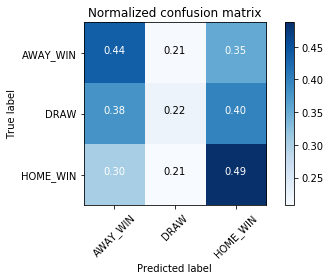

In [71]:
print("******************************\nK-NeighboursCLASSIFIER (Test Data):\n******************************")

#y_test_pred = cross_val_predict(KB_clf, X_test, y_test, cv=3)
conf_mxPRED = confusion_matrix(y_test, y_pred)
print(conf_mxPRED)

# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mxPRED, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [72]:
# VOTING CLASSIFIER

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time
start_time = time.time()

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability = True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

elapsed = time.time() - start_time
round(elapsed, 1)
print("The amont of time elapsed was ", round(elapsed, 2), " seconds.")

The amont of time elapsed was  505.63  seconds.



***************************
LogisticRegression
 With Draws, All Features:
***************************
F-Beta Score:  0.5362827715355806
Precision Score:  0.5362827715355806
Recall Score:  0.5362827715355806
[[ 611    0  616]
 [ 287    0  775]
 [ 303    0 1680]]
Normalized confusion matrix
[[0.5  0.   0.5 ]
 [0.27 0.   0.73]
 [0.15 0.   0.85]]
********************************
 LogisticRegression 
********************************


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


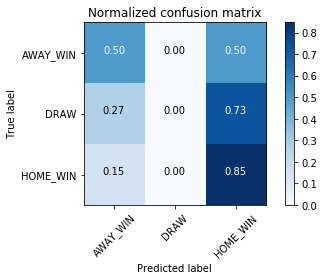

LogisticRegression  Accuracy Score :  0.5362827715355806

***************************
RandomForestClassifier
 With Draws, All Features:
***************************
F-Beta Score:  0.5175561797752809
Precision Score:  0.5175561797752809
Recall Score:  0.5175561797752809
[[ 638  201  388]
 [ 308  229  525]
 [ 354  285 1344]]
Normalized confusion matrix
[[0.52 0.16 0.32]
 [0.29 0.22 0.49]
 [0.18 0.14 0.68]]
********************************
 RandomForestClassifier 
********************************


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


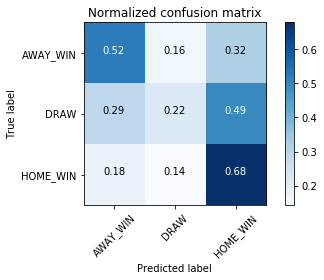

********************************
Feature Importances:
********************************
HOME_DRAW_RATE 0.042167085529735436
HOME_DRAW_RATE_THIS_SEASON 0.031694020436581
AWAY_DRAW_RATE 0.04346862422570239
AWAY_DRAW_RATE_THIS_SEASON 0.03210492294507519
AWAY_DRAW_RATE_AT_THIS_GROUND 0.04213266052078656
num_top_players_home 0.009726160990296287
num_top_players_away 0.011125103702511649
num_bottom_players_home 0.001050321290794959
num_bottom_players_away 0.0011462336881655993
home_team_api_id 0.03940166005181312
away_team_api_id 0.03742055382281992
away_Attacker_rating 0.037854342511564956
home_Attacker_rating 0.039899336595219895
away_Defender_rating 0.04612948822563846
home_Defender_rating 0.045497966996948344
away_Goalkeeper_rating 0.032613813699769345
home_Goalkeeper_rating 0.031647275090187534
away_Midfielder_rating 0.04573477020202383
home_Midfielder_rating 0.045672930937208096
HEAD_2_HEAD_HOME_TEAM_WINS 0.03188241366575377
HEAD_2_HEAD_HOME_TEAM_LOSS 0.03310636317645281
HEAD_2_HEAD_DRA

/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


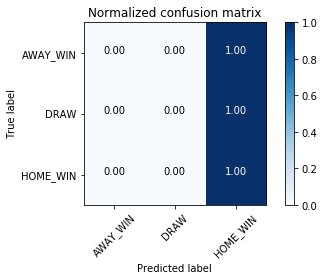

SVC  Accuracy Score :  0.46418539325842695

***************************
VotingClassifier
 With Draws, All Features:
***************************
F-Beta Score:  0.5407303370786517
Precision Score:  0.5407303370786517
Recall Score:  0.5407303370786517
[[ 518   47  662]
 [ 211   37  814]
 [ 195   33 1755]]
Normalized confusion matrix
[[0.42 0.04 0.54]
 [0.2  0.03 0.77]
 [0.1  0.02 0.89]]
********************************
 VotingClassifier 
********************************


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


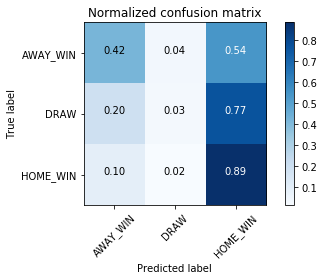

VotingClassifier  Accuracy Score :  0.5407303370786517
The amont of time elapsed was  1031.01  seconds.


In [73]:
from sklearn.metrics import accuracy_score
import time
start_time = time.time()

# Results of running the algorithms above with "soft" voting, rather than hard voting
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print("\n***************************")
    print(clf.__class__.__name__)   
    print(" With Draws, All Features:\n***************************")
    print("F-Beta Score: ", fbeta_score(y_test, y_pred, average = 'micro', beta = 1))
    print("Precision Score: ", precision_score(y_test, y_pred, average='micro'))
    print("Recall Score: ", recall_score(y_test, y_pred, average='micro'))


    conf_mxPRED = confusion_matrix(y_test, y_pred)
    print(conf_mxPRED)
    # Plot normalized confusion matrix
    class_names = le.inverse_transform([0,1,2])
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(conf_mxPRED, classes=class_names, normalize=True,
                      title= 'Normalized confusion matrix')
    print("********************************\n", clf.__class__.__name__, "\n********************************")
    plt.show()
    
    if(clf == rnd_clf):
        print("********************************\nFeature Importances:\n********************************")
        for name, score in zip(list(X_train), clf.feature_importances_):
            print(name, score)
        print("********************************/n")
    print(clf.__class__.__name__, " Accuracy Score : ", accuracy_score(y_test, y_pred))
    
elapsed = time.time() - start_time
print("The amont of time elapsed was ", round(elapsed, 2), " seconds.")

In [92]:
# TRAIN MultiLayer Perceptron Classifier (MLP)
import time
start_time = time.time()
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes= (30, 30), alpha=1e-3, learning_rate = 'adaptive', 
                        learning_rate_init = 0.0001,max_iter = 15, activation='tanh', 
                        batch_size = 100, early_stopping = True)

MLP_result = cross_val_predict(mlp_clf, X_train, y_train, cv=3)
print(cross_val_score(mlp_clf, X_train, y_train, cv=3, scoring="accuracy"))

mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
print(mlp_clf.__class__.__name__, " Accuracy Score : ", accuracy_score(y_test, y_pred))

# NO draws
mlp_clfND = MLPClassifier(solver='lbfgs', alpha=1e-8,
                   hidden_layer_sizes=(15, 15), random_state=1)

MLP_resultND = cross_val_predict(mlp_clfND, X_trainND, y_trainND, cv=2)
print(cross_val_score(mlp_clfND, X_trainND, y_trainND, cv=2, scoring="accuracy"))

mlp_clfND.fit(X_trainND, y_trainND)
y_predND = mlp_clfND.predict(X_testND)
print(mlp_clfND.__class__.__name__, " Accuracy Score : ", accuracy_score(y_testND, y_predND))

elapsed = time.time() - start_time
print("The amont of time elapsed was ", round(elapsed, 2), " seconds.")

[0.46 0.46 0.46]
MLPClassifier  Accuracy Score :  0.46324906367041196
[0.61 0.61]
MLPClassifier  Accuracy Score :  0.6257438145944253
The amont of time elapsed was  3.94  seconds.


******************************
With Draws, Multi-Layer Perceptron CLASSIFIER (Train Set):
******************************
[[   6    0 1221]
 [   8    0 1054]
 [  10    0 1973]]
F-Beta Score:  0.2967168328490092
Precision Score:  0.2873974732326118
Recall Score:  0.46324906367041196
Normalized confusion matrix
[[0.   0.   1.  ]
 [0.01 0.   0.99]
 [0.01 0.   0.99]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


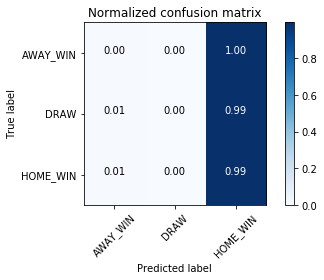


******************************
No Draws, Multi-Layer Perceptron CLASSIFIER:
******************************
[[   0 1195]
 [   0 1998]]
F-Beta Score:  0.48169375517613633
Precision Score:  0.3915553215031825
Recall Score:  0.6257438145944253
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


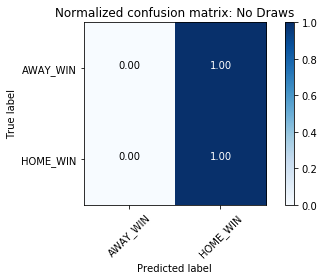

In [93]:
print("******************************\nWith Draws, Multi-Layer Perceptron CLASSIFIER (Train Set):\n******************************")
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

print("F-Beta Score: ", fbeta_score(y_test, y_pred, average = 'weighted', beta = 1))
print("Precision Score: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score: ", recall_score(y_test, y_pred, average='weighted'))

# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

print("\n******************************\nNo Draws, Multi-Layer Perceptron CLASSIFIER:\n******************************")
conf_mxND = confusion_matrix(y_testND, y_predND)
print(conf_mxND)

print("F-Beta Score: ", fbeta_score(y_testND, y_predND, average = 'weighted', beta = 1))
print("Precision Score: ", precision_score(y_testND, y_predND, average='weighted'))
print("Recall Score: ", recall_score(y_testND, y_predND, average='weighted'))

# Plot normalized confusion matrix
class_namesND = le_draw.inverse_transform([0,1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mxND, classes=class_namesND, normalize=True,
                      title='Normalized confusion matrix: No Draws')
plt.show()

In [87]:
# TRAIN ADABOOST classifier
import time
start_time = time.time()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# WITH draws
ADA_clf = AdaBoostClassifier(base_estimator= RandomForestClassifier(n_estimators=100, max_depth=2),
                         algorithm="SAMME.R",
                         n_estimators=500)
ADA_result = cross_val_predict(ADA_clf, X_train, y_train, cv=3)
print(cross_val_score(ADA_clf, X_train, y_train, cv=3, scoring="accuracy"))

ADA_clf.fit(X_train, y_train)
y_pred = ADA_clf.predict(X_test)
print(ADA_clf.__class__.__name__, " Accuracy Score : ", accuracy_score(y_test, y_pred))

# NO draws
ADA_clfND = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME.R",
                         n_estimators=100)

ADA_resultND = cross_val_predict(ADA_clfND, X_trainND, y_trainND, cv=3)
print(cross_val_score(ADA_clfND, X_trainND, y_trainND, cv=3, scoring="accuracy"))

ADA_clfND.fit(X_trainND, y_trainND)
y_predND = ADA_clfND.predict(X_testND)
print(ADA_clfND.__class__.__name__, " Accuracy Score : ", accuracy_score(y_testND, y_predND))

elapsed = time.time() - start_time
print("The amont of time elapsed was ", round(elapsed, 2), " seconds.")

[0.54 0.53 0.53]
AdaBoostClassifier  Accuracy Score :  0.5596910112359551
[0.73 0.71 0.7 ]
AdaBoostClassifier  Accuracy Score :  0.7303476354525524
The amont of time elapsed was  4566.45  seconds.


******************************
With Draws, ADA BOOST CLASSIFIER:
******************************
[[ 646  115  466]
 [ 227  180  655]
 [ 254  164 1565]]
F-Beta Score:  0.5276604272589603
Precision Score:  0.532581322106675
Recall Score:  0.5596910112359551
Normalized confusion matrix
[[0.53 0.09 0.38]
 [0.21 0.17 0.62]
 [0.13 0.08 0.79]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


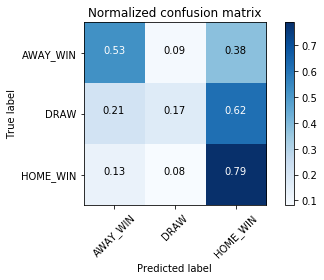


******************************
No Draws, ADA BOOST CLASSIFIER:
******************************


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[ 633  562]
 [ 299 1699]]
F-Beta Score:  0.7220023334802482
Precision Score:  0.7243963344161374
Recall Score:  0.7303476354525524
Normalized confusion matrix
[[0.53 0.47]
 [0.15 0.85]]


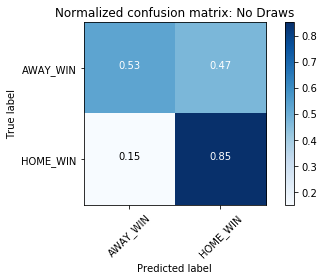

In [88]:
print("******************************\nWith Draws, ADA BOOST CLASSIFIER:\n******************************")
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

print("F-Beta Score: ", fbeta_score(y_test, y_pred, average = 'weighted', beta = 1))
print("Precision Score: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score: ", recall_score(y_test, y_pred, average='weighted'))

# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

print("\n******************************\nNo Draws, ADA BOOST CLASSIFIER:\n******************************")
conf_mxND = confusion_matrix(y_testND, y_predND)
print(conf_mxND)

print("F-Beta Score: ", fbeta_score(y_testND, y_predND, average = 'weighted', beta = 1))
print("Precision Score: ", precision_score(y_testND, y_predND, average='weighted'))
print("Recall Score: ", recall_score(y_testND, y_predND, average='weighted'))

# Plot normalized confusion matrix
class_namesND = le_draw.inverse_transform([0,1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mxND, classes=class_namesND, normalize=True,
                      title='Normalized confusion matrix: No Draws')
plt.show()

In [89]:
import time
start_time = time.time()

from sklearn.ensemble import GradientBoostingClassifier

# GRADIENT with Draws
gbc_clf = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=1.0, random_state=1)
gbc_clf.fit(X_train, y_train)

GBC_result = cross_val_predict(gbc_clf, X_train, y_train, cv=3)
print(cross_val_score(gbc_clf, X_train, y_train, cv=3, scoring="accuracy"))
gbc_clf.fit(X_train, y_train)
y_pred = gbc_clf.predict(X_test)
print(gbc_clf.__class__.__name__, " Accuracy Score : ", accuracy_score(y_test, y_pred))

#Gradient without Draws
gbc_clfND = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=1.0, random_state=1)
gbc_clfND.fit(X_trainND, y_trainND)

GBC_resultND = cross_val_predict(gbc_clfND, X_trainND, y_trainND, cv=3)
print(cross_val_score(gbc_clfND, X_trainND, y_trainND, cv=3, scoring="accuracy"))
gbc_clfND.fit(X_trainND, y_trainND)
y_predND = gbc_clfND.predict(X_testND)
print(gbc_clfND.__class__.__name__, " Accuracy Score : ", accuracy_score(y_testND, y_predND))

elapsed = time.time() - start_time
print("The amont of time elapsed was ", round(elapsed, 2), " seconds.")

[0.53 0.52 0.52]
GradientBoostingClassifier  Accuracy Score :  0.5484550561797753
[0.73 0.72 0.71]
GradientBoostingClassifier  Accuracy Score :  0.7328531161916693
The amont of time elapsed was  34.65  seconds.


******************************
With Draws, Gradient Boost CLASSIFIER:
******************************
[[2468  708 1755]
 [1004  809 2521]
 [1119  993 5711]]
F-Beta Score:  0.5197047583405948
Precision Score:  0.5185601883833421
Recall Score:  0.5484550561797753
Normalized confusion matrix
[[0.5  0.14 0.36]
 [0.23 0.19 0.58]
 [0.14 0.13 0.73]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


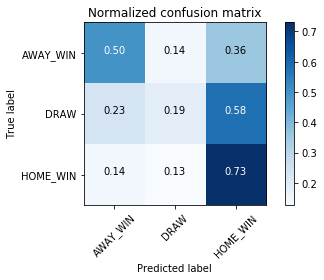


******************************
No Draws, Gradient Boost CLASSIFIER:
******************************
[[2655 2308]
 [1330 6478]]
F-Beta Score:  0.7272732171300345
Precision Score:  0.7273745558646546
Recall Score:  0.7328531161916693
Normalized confusion matrix
[[0.53 0.47]
 [0.17 0.83]]


/Users/sebastiennunes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


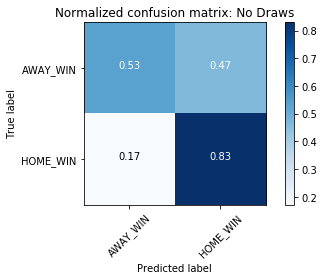

In [90]:
print("******************************\nWith Draws, Gradient Boost CLASSIFIER:\n******************************")
y_train_pred = GBC_result
conf_mx = confusion_matrix(y_train, y_train_pred)
#conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
print(conf_mx)

print("F-Beta Score: ", fbeta_score(y_test, y_pred, average = 'weighted', beta = 1))
print("Precision Score: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score: ", recall_score(y_test, y_pred, average='weighted'))

# Plot normalized confusion matrix
class_names = le.inverse_transform([0,1,2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

print("\n******************************\nNo Draws, Gradient Boost CLASSIFIER:\n******************************")
y_train_predND = ADA_resultND
conf_mxND = confusion_matrix(y_trainND, y_train_predND)
#conf_mxND = conf_mxND.astype('float') / conf_mxND.sum(axis=1)[:, np.newaxis]
print(conf_mxND)

print("F-Beta Score: ", fbeta_score(y_testND, y_predND, average = 'weighted', beta = 1))
print("Precision Score: ", precision_score(y_testND, y_predND, average='weighted'))
print("Recall Score: ", recall_score(y_testND, y_predND, average='weighted'))

# Plot normalized confusion matrix
class_namesND = le_draw.inverse_transform([0,1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mxND, classes=class_namesND, normalize=True,
                      title='Normalized confusion matrix: No Draws')
plt.show()